In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
sys.path.append("../src")

import rna_transform.utils as utils
from rna_transform.rna_helper import RNAHelper
from qspright.utils import best_convex_underestimator
from rna_transform.rna_tests import run_accuracy_tests
import itertools

In [2]:
positions = [5, 8, 10, 12, 15, 20, 22, 25, 38]

query_args = {
    "query_method": "complex",
    "delays_method": "nso",
    "num_subsample": 4,
    "num_random_delays": 4,
    "b": 6
}

helper = RNAHelper(positions, subsampling = True, query_args = query_args)
n = helper.n
q = helper.q

print("n = {}, N = {:.2e}".format(n, q ** n))

{'signal': 'results/rna_subsampled.pickle'}
n = 9, N = 2.62e+05


## Test QSPRIGHT with different parameters

Construct a grid of parameters. For each entry, run multiple test rounds. Compute the average for each parameter selection. 

In [3]:
# iters = 1
# num_subsample_list = [4, 5, 6, 7]
# num_random_delays_list = [4, 6, 8, 10]
# b_list = [4, 5, 6, 7]

iters = 1
num_subsample_list = [2, 4]
num_random_delays_list = [2, 4]
b_list = [4, 5, 6]

result = run_accuracy_tests(helper, iters, num_subsample_list, num_random_delays_list, b_list)
    
sample_ratios, unique_sample_ratios, accs = result

  0%|          | 0/12 [00:00<?, ?it/s]

(9, 10240)
2 20


  8%|▊         | 1/12 [00:00<00:10,  1.03it/s]

(9, 40960)
2 20


 17%|█▋        | 2/12 [00:03<00:16,  1.64s/it]

(9, 163840)
2 20


 25%|██▌       | 3/12 [00:08<00:28,  3.22s/it]

(9, 20480)
2 40


 33%|███▎      | 4/12 [00:08<00:18,  2.28s/it]

(9, 81920)
2 40


 42%|████▏     | 5/12 [00:11<00:16,  2.33s/it]

(9, 327680)
2 40


 50%|█████     | 6/12 [00:17<00:21,  3.56s/it]

(9, 20480)
4 20


 58%|█████▊    | 7/12 [00:20<00:16,  3.33s/it]

(9, 81920)
4 20


 67%|██████▋   | 8/12 [00:24<00:14,  3.55s/it]

(9, 327680)
4 20


 75%|███████▌  | 9/12 [00:34<00:17,  5.67s/it]

(9, 40960)
4 40


 83%|████████▎ | 10/12 [00:35<00:08,  4.26s/it]

(9, 163840)
4 40


 92%|█████████▏| 11/12 [00:38<00:03,  3.83s/it]

(9, 655360)
4 40


100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


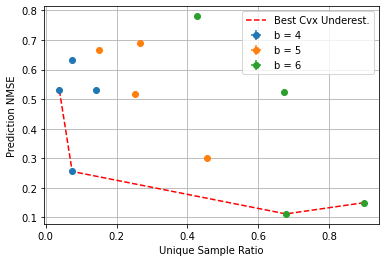

In [4]:
all_points = np.zeros(shape=[0,2])

for i, b in enumerate(b_list):
    s_values = np.mean(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(accs[:, :, i, :], axis=-1).flatten()
    s_std = np.std(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_std =  np.std(accs[:, :, i, :], axis=-1).flatten()
    
    plt.errorbar(s_values, mse_values, xerr= s_std, yerr= mse_std, label = "b = {}".format(b), fmt="o")
        
    all_points = np.concatenate((all_points, np.array([s_values, mse_values]).T), axis = 0)

if len(all_points) > 3:
    bcue = best_convex_underestimator(all_points)
    plt.plot(bcue[:,0], bcue[:,1], 'r--', lw=1.5, label="Best Cvx Underest.")

plt.xlabel('Unique Sample Ratio')
plt.ylabel('Prediction NMSE')
plt.legend()
plt.grid()
plt.savefig('figs/acc-vs-unique-sample-ratio.png')
plt.show()

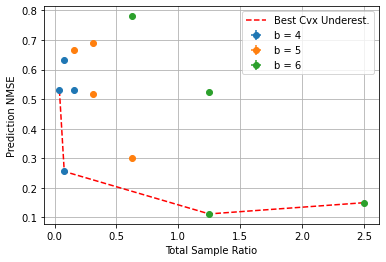

In [5]:
all_points = np.zeros(shape=[0,2])

for i, b in enumerate(b_list):
    s_values = np.mean(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(accs[:, :, i, :], axis=-1).flatten()
    s_std = np.std(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_std =  np.std(accs[:, :, i, :], axis=-1).flatten()

    plt.errorbar(s_values, mse_values, xerr= s_std, yerr= mse_std, label = "b = {}".format(b), fmt="o")

    all_points = np.concatenate((all_points, np.array([s_values, mse_values]).T), axis = 0)

if len(all_points) > 3:
    bcue = best_convex_underestimator(all_points)
    plt.plot(bcue[:,0], bcue[:,1], 'r--', lw=1.5, label="Best Cvx Underest.")

plt.xlabel('Total Sample Ratio')
plt.ylabel('Prediction NMSE')
plt.legend()
plt.grid()
plt.savefig('figs/acc-vs-total-sample-ratio.png')
plt.show()